In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import src.util as util
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
config_data = util.load_config()

In [3]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load every set of data
    x_train = util.pickle_load(config_data["train_set_path"]['x'])
    y_train = util.pickle_load(config_data["train_set_path"]['y'])

    x_valid = util.pickle_load(config_data["valid_set_path"]['x'])
    y_valid = util.pickle_load(config_data["valid_set_path"]['y'])

    x_test = util.pickle_load(config_data["test_set_path"]['x'])
    y_test = util.pickle_load(config_data["test_set_path"]['y'])

    # Concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis = 1)
    valid_set = pd.concat([x_valid, y_valid], axis = 1)
    test_set = pd.concat([x_test, y_test], axis = 1)

    # Return 3 set of data
    return train_set, valid_set, test_set

In [4]:
train_set, valid_set, test_set = load_dataset(config_data)

# Handling Missing Value (if any)

In [5]:
display(train_set.isnull().sum())
display(valid_set.isnull().sum())
display(test_set.isnull().sum())

JobLevel                   0
Age                        0
DistanceFromHome           0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
MonthlyIncome              0
MonthlyRate                0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
PerformanceRating          0
Department                 0
JobRole                    0
Gender                     0
OverTime                   0
Attrition                  0
dtype: int64

JobLevel                   0
Age                        0
DistanceFromHome           0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
MonthlyIncome              0
MonthlyRate                0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
PerformanceRating          0
Department                 0
JobRole                    0
Gender                     0
OverTime                   0
Attrition                  0
dtype: int64

JobLevel                   0
Age                        0
DistanceFromHome           0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
MonthlyIncome              0
MonthlyRate                0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
PerformanceRating          0
Department                 0
JobRole                    0
Gender                     0
OverTime                   0
Attrition                  0
dtype: int64

In [6]:
impute_values = config_data['missing_value_handling']
train_set.fillna(value=impute_values, inplace=True)
valid_set.fillna(value=impute_values, inplace=True)
test_set.fillna(value=impute_values, inplace=True)


# One-Hot Encoding for Categorical Vairables

In [7]:
def ohe_fit(categorical_attribute, ohe_model_path):
    ohe = OneHotEncoder(sparse_output=False)
    ohe.fit(np.array(categorical_attribute).reshape(-1, 1))
    util.pickle_dump(ohe, ohe_model_path)
    return ohe

In [8]:
def ohe_transform(set_data: pd.DataFrame, transformed_column: str, ohe_path: str) -> pd.DataFrame:
    set_data = set_data.copy()
    ohe = util.pickle_load(ohe_path)

    features = ohe.transform(np.array(set_data[transformed_column].to_list()).reshape(-1, 1))
    features = pd.DataFrame(features.tolist(), columns=ohe.get_feature_names_out([transformed_column]))
    
    features.set_index(set_data.index, inplace=True)
    set_data = pd.concat([features, set_data], axis=1)
    set_data.drop(columns=transformed_column, inplace=True)

    new_col = [str(col_name) for col_name in set_data.columns.to_list()]
    set_data.columns = new_col

    return set_data

In [9]:
ohe_Department = ohe_fit(config_data['Department_range'], config_data['ohe_Department_path'])
ohe_JobRole = ohe_fit(config_data['JobRole_range'], config_data['ohe_JobRole_path'])
ohe_Gender = ohe_fit(config_data['Gender_range'], config_data['ohe_Gender_path'])
ohe_OverTime = ohe_fit(config_data['OverTime_range'], config_data['ohe_OverTime_path'])

In [10]:
for col in ['Department', 'JobRole', 'Gender', 'OverTime']:
    train_set = ohe_transform(train_set, col, config_data[f"ohe_{col}_path"])
    valid_set = ohe_transform(valid_set, col, config_data[f"ohe_{col}_path"])
    test_set = ohe_transform(test_set, col, config_data[f"ohe_{col}_path"])

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 853 to 1292
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OverTime_No                        1029 non-null   float64
 1   OverTime_Yes                       1029 non-null   float64
 2   Gender_Female                      1029 non-null   float64
 3   Gender_Male                        1029 non-null   float64
 4   JobRole_Healthcare Representative  1029 non-null   float64
 5   JobRole_Human Resources            1029 non-null   float64
 6   JobRole_Laboratory Technician      1029 non-null   float64
 7   JobRole_Manager                    1029 non-null   float64
 8   JobRole_Manufacturing Director     1029 non-null   float64
 9   JobRole_Research Director          1029 non-null   float64
 10  JobRole_Research Scientist         1029 non-null   float64
 11  JobRole_Sales Executive            1029 non-null   flo

# Balancing Label
*Only for train dataset*

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def attrition_count_plot(dataset):
    plt.figure(figsize=(5,3))
    ax = sns.countplot(data=dataset, x='Attrition', hue='Attrition', palette='dark:skyblue', edgecolor='black')
    total_height = len(dataset)
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total_height) * 100
        ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    sns.despine()
    plt.show()

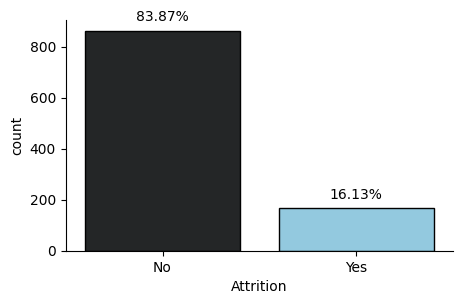

In [13]:
attrition_count_plot(train_set)

In [14]:
def rus_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    rus = RandomUnderSampler(random_state = 42)
    x_rus, y_rus = rus.fit_resample(set_data.drop("Attrition", axis = 1), set_data['Attrition'])
    set_data_rus = pd.concat([x_rus, y_rus], axis = 1)
    return set_data_rus

def ros_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    ros = RandomOverSampler(random_state = 11)
    x_ros, y_ros = ros.fit_resample(set_data.drop("Attrition", axis = 1), set_data['Attrition'])
    set_data_ros = pd.concat([x_ros, y_ros], axis = 1)
    return set_data_ros

def sm_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    sm = SMOTE(random_state = 112)
    x_sm, y_sm = sm.fit_resample(set_data.drop("Attrition", axis = 1), set_data['Attrition'])
    set_data_sm = pd.concat([x_sm, y_sm], axis = 1)
    return set_data_sm

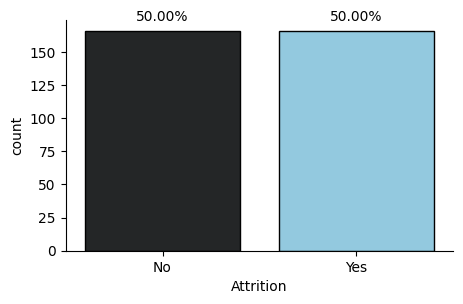

In [15]:
train_set_rus = rus_fit_resample(train_set)
attrition_count_plot(train_set_rus)

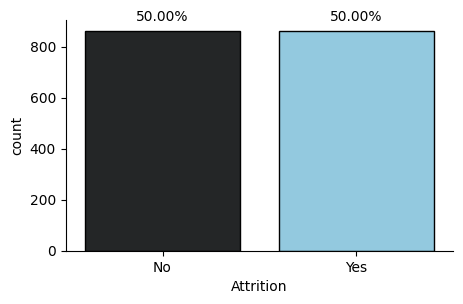

In [16]:
train_set_ros = ros_fit_resample(train_set)
attrition_count_plot(train_set_ros)

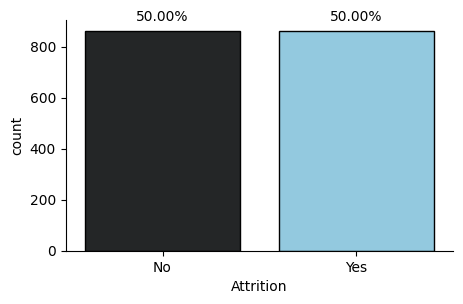

In [17]:
train_set_sm = sm_fit_resample(train_set)
attrition_count_plot(train_set_sm)

# Label Encoding

In [18]:
def le_fit(data_tobe_fitted: dict, le_path: str) -> LabelEncoder:
    le_encoder = LabelEncoder()
    le_encoder.fit(data_tobe_fitted)
    util.pickle_dump(le_encoder, le_path)
    return le_encoder

In [19]:
le_encoder = le_fit(config_data["Attrition_range"], config_data["le_encoder_path"])

In [20]:
def le_transform(label_data: pd.Series, config_data: dict) -> pd.Series:
    label_data = label_data.copy()
    le_encoder = util.pickle_load(config_data["le_encoder_path"])

    # If categories both label data and trained le matched
    if len(set(label_data.unique()) - set(le_encoder.classes_) | set(le_encoder.classes_) - set(label_data.unique())) == 0:
        label_data = le_encoder.transform(label_data)
    else:
        raise RuntimeError("Check category in label data and label encoder.")

    return label_data

In [21]:
train_set['Attrition'] = le_transform(train_set['Attrition'], config_data)
train_set_rus['Attrition'] = le_transform(train_set_rus['Attrition'], config_data)
train_set_ros['Attrition'] = le_transform(train_set_ros['Attrition'], config_data)
train_set_sm['Attrition'] = le_transform(train_set_sm['Attrition'], config_data)

valid_set['Attrition'] = le_transform(valid_set['Attrition'], config_data)
test_set['Attrition'] = le_transform(test_set['Attrition'], config_data)

In [22]:
train_set.Attrition.value_counts()

0    863
1    166
Name: Attrition, dtype: int64

In [23]:
x_train = {
    "No sampling" : train_set.drop(columns = "Attrition"),
    "Undersampling" : train_set_rus.drop(columns = "Attrition"),
    "Oversampling" : train_set_ros.drop(columns = "Attrition"),
    "SMOTE" : train_set_sm.drop(columns = "Attrition")
}

y_train = {
    "No sampling" : train_set.Attrition,
    "Undersampling" : train_set_rus.Attrition,
    "Oversampling" : train_set_ros.Attrition,
    "SMOTE" : train_set_sm.Attrition
}

In [24]:
util.pickle_dump(x_train, config_data['train_set_feng_path']['x'])
util.pickle_dump(y_train, config_data['train_set_feng_path']['y'])

util.pickle_dump(valid_set.drop(columns = "Attrition"), config_data['valid_set_feng_path']['x'])
util.pickle_dump(valid_set.Attrition, config_data['valid_set_feng_path']['y'])

util.pickle_dump(test_set.drop(columns = "Attrition"), config_data['test_set_feng_path']['x'])
util.pickle_dump(test_set.Attrition, config_data['test_set_feng_path']['y'])